# Projet 2

## consigne

Mark, votre manager, vous a convié à une réunion pour vous présenter le projet d’expansion à l’international de l’entreprise. Il vous confie une première mission d’analyse exploratoire, pour déterminer si les données sur l’éducation de la banque mondiale permettent d’informer le projet d’expansion.

Voici les différentes questions que Mark aimerait explorer, que vous avez notées durant la réunion :

 - Quels sont les pays avec un fort potentiel de clients pour nos services ?
 - Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
 - Dans quels pays l'entreprise doit-elle opérer en priorité ?
Votre mission
Mark vous a donc demandé de réaliser une analyse pré-exploratoire de ce jeu de données. Il vous a transmis cet email à la suite de la réunion :

***
Hello,

Les données de la Banque mondiale sont disponibles à l’adresse suivante :

https://datacatalog.worldbank.org/dataset/education-statistics

Ou en téléchargement direct à ce lien.

Je te laisse regarder la page d'accueil qui décrit le jeu de données. En résumé, l’organisme “EdStats All Indicator Query” de la Banque mondiale répertorie 4000 indicateurs internationaux décrivant l’accès à l’éducation, l’obtention de diplômes et des informations relatives aux professeurs, aux dépenses liées à l’éducation... Tu trouveras plus d'info sur ce site :

http://datatopics.worldbank.org/education/

Pour la pré-analyse, pourrais-tu :

 - Valider la qualité de ce jeu de données (comporte-t-il beaucoup de données manquantes, dupliquées ?)
 - Décrire les informations contenues dans le jeu de données (nombre de colonnes ? nombre de lignes ?)
 - Sélectionner les informations qui semblent pertinentes pour répondre à la problématique (quelles sont les colonnes contenant des informations qui peuvent être utiles pour répondre à la problématique de l’entreprise ?)
 - Déterminer des ordres de grandeurs des indicateurs statistiques classiques pour les différentes zones géographiques et pays du monde (moyenne/médiane/écart-type par pays et par continent ou bloc géographique)
 
Ton travail va nous permettre de déterminer si ce jeu de données peut informer les décisions d'ouverture vers de nouveaux pays. On va partager ton analyse avec le board, alors merci de soigner la présentation et de l'illustrer avec des graphiques pertinents et lisibles !
***

Livrables attendus
 - Un notebook comportant les analyses pré-exploratoires réalisées (non cleané, pour comprendre votre démarche).
 - Un support de présentation pour la soutenance.

## import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno
import ipywidgets as widgets

from datetime import datetime, timezone, timedelta, date
from IPython.display import display as Idisplay
from IPython.display import clear_output
from ipywidgets.embed import embed_minimal_html
from matplotlib import pylab

import warnings
warnings.filterwarnings('ignore')

## import des données

In [2]:
EdStatsCountry = pd.read_csv("csv_data/EdStatsCountry.csv")
EdStatsCountry_Series = pd.read_csv("csv_data/EdStatsCountry-Series.csv")
EdStatsData = pd.read_csv("csv_data/EdStatsData.csv")
EdStatsFootNote = pd.read_csv("csv_data/EdStatsFootNote.csv")
EdStatsSeries = pd.read_csv("csv_data/EdStatsSeries.csv")

for t in np.unique(EdStatsSeries["Topic"]):
    print(f'\n{t}\n')
    print(np.unique(EdStatsSeries[["Topic", "Indicator Name"]][EdStatsSeries["Topic"]==t]))

## premier regard sur les données

premier coup d'oeuil avec une carte des liens entre les tables

![title](table_chart.png)

***
### affichage des données manquantes sous forme de matrice binaire (Noir = manquant, Blanc = présent)

In [3]:
Tables = [EdStatsCountry, EdStatsCountry_Series, EdStatsData, EdStatsFootNote, EdStatsSeries]
T_Names = ["EdStatsCountry", "EdStatsCountry-Series", "EdStatsData", "EdStatsFootNote", "EdStatsSeries"]
for t,n in zip(Tables, T_Names):
    t.name = n
Stats = {}

def draw_missing_values(ds_str, fig, ax):
    t = Tables[T_Names.index(ds_str)]
    check = np.vectorize(lambda x : x!=x)
    Stats[t.name] = {"missing" : check(t.to_numpy()), "data" : t}
    msno.matrix(t, ax=ax, sparkline=False)
    ax.set_title(t.name)
    fig.tight_layout(pad=2)

<IPython.core.display.Javascript object>


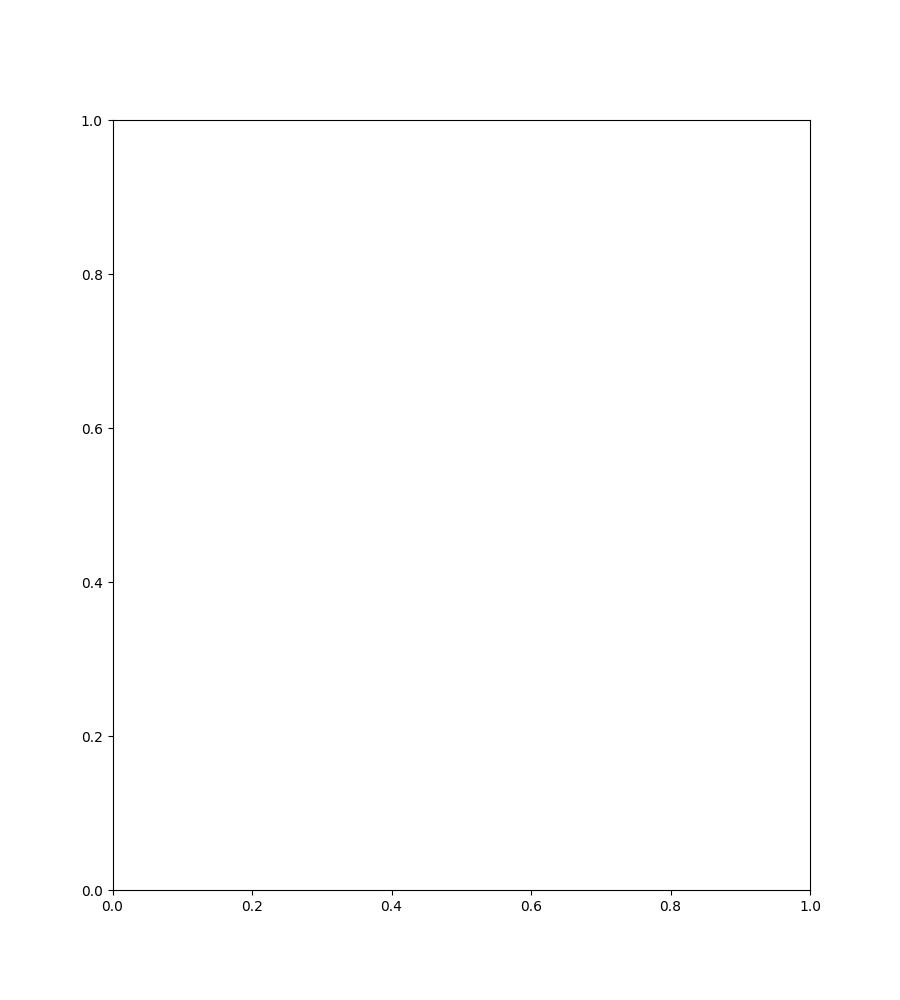

Dropdown(options=('EdStatsCountry', 'EdStatsCountry-Series', 'EdStatsData', 'EdStatsFootNote', 'EdStatsSeries'…

In [4]:
msnowidget = widgets.Dropdown(options=T_Names)

fig, ax = plt.subplots(figsize=(9,10))

def msnowidget_eventhandler(change):
    draw_missing_values(change.new, fig, ax)

msnowidget.observe(msnowidget_eventhandler, names='value')
Idisplay(msnowidget)

***
### sélection des indicateurs pertinents

In [5]:
indicators = np.unique(EdStatsData["Indicator Name"].to_numpy())

selection_mask = np.array([n in indicators for n in EdStatsSeries["Indicator Name"]])
selection_codes = EdStatsSeries["Series Code"][selection_mask].to_numpy()

countries = np.unique(EdStatsData["Country Name"].to_numpy())

code_mask = np.array([c in selection_codes for c in EdStatsData["Indicator Code"]])
state_mask = np.array([c in countries for c in EdStatsData["Country Name"]])

In [6]:
def get_Y_values(dataframe, indicator:str, country:str):
    X_string = [str(x.year) for x in X]
    indicator_mask = np.array([i == indicator for i in EdStatsData["Indicator Name"].to_numpy()])
    country_mask = np.array([c == country for c in EdStatsData["Country Name"].to_numpy()])
    return EdStatsData[X_string][indicator_mask*country_mask].to_numpy().ravel()

def get_indi_missing(dataframe, indicator:str):
    X_string = [str(x.year) for x in X]
    indicator_mask = np.array([i == indicator for i in EdStatsData["Indicator Name"].to_numpy()])
    N = len(EdStatsData[X_string][indicator_mask].to_numpy().ravel())
    return EdStatsData[X_string][indicator_mask].isna().sum(axis=1).to_numpy(), EdStatsData[X_string][indicator_mask].isna().sum(axis=0).to_numpy(), N

def get_cty_missing(dataframe, country:str):
    X_string = [str(x.year) for x in X]
    country_mask = np.array([c == country for c in EdStatsData["Country Name"].to_numpy()])
    N = len(EdStatsData[X_string][country_mask].to_numpy().ravel())
    return EdStatsData[X_string][country_mask].isna().sum(axis=1).to_numpy(), EdStatsData[X_string][country_mask].isna().sum(axis=0).to_numpy(), N

def get_indi_by_cty(dataframe, indicator:str):
    X_string = [str(x.year) for x in X]
    indicator_mask = np.array([i == indicator for i in EdStatsData["Indicator Name"].to_numpy()])
    return EdStatsData[X_string][indicator_mask].to_numpy()

In [7]:
X = [date(year, 1, 1) for year in list(range(1970,2018,1))+list(range(2020,2101,5))]
X_string = [str(x.year) for x in X]

In [8]:
dates = X
options = [(d.strftime('%Y'), d) for d in dates]
date_slider = widgets.SelectionRangeSlider(options=options,
                                           index=(0,55),
                                           description='Période',
                                           disabled=False)

indicators_combobox = widgets.Combobox(
    value='Population, total',
    placeholder='',
    options=list(indicators),
    description='Indicator',
    ensure_option=True,
    disabled=False
)

countries_combobox = widgets.Combobox(
    value='France',
    placeholder='',
    options=list(countries),
    description='Country',
    ensure_option=True,
    disabled=False
)

In [9]:
class Displayer :
    
    def __init__(self, DS, code, country):
        self.dataset = DS
        self.code = code
        self.country = country
        self.X = np.array(dates)
        self.d_start = min(self.X)
        self.d_end = max(self.X)
        self.mask = np.full(len(self.X), True)
        self.fig, self.ax = None, None
        self.fig1, self.ax1 = None, None
        self.fig2, self.ax2 = None, None
        self.out = widgets.Output()
        self.indi_miss = widgets.Output()
        self.cty_miss = widgets.Output()
    
    def change_dates(self, new_date_start, new_date_end):
        self.d_start = new_date_start
        self.d_end = new_date_end
        self._UPDATE_MASK()
    
    def change_country(self, new_country):
        self.country = new_country
    
    def change_code(self, new_code):
        self.code = new_code
    
    def _UPDATE_MASK(self):
        self.mask = np.array([self.d_start <= date <= self.d_end for date in self.X])
    
    def _plot(self):
        self.out.clear_output()
        with self.out :
            if self.fig==None :
                self.fig, self.ax = plt.subplots(figsize=(9,6), 
                                                 num=f"{self.country}-{self.code}")
            else :
                self.fig.set(label = f"{self.country}-{self.code}")
            fig, ax = self.fig, self.ax
            ax.clear()
            ax.plot(self.X[self.mask], 
                    get_Y_values(self.dataset, self.code, self.country)[self.mask],
                    zorder=1)

            ax.grid(zorder=0)
            fig.tight_layout()
            Idisplay(fig)
    
    def _indicator_missing(self):
        self.indi_miss.clear_output()
        with self.indi_miss :
            if self.fig1==None :
                self.fig1, self.ax1 = plt.subplots(3, 1, 
                                                   figsize=(9,35), 
                                                   height_ratios = [15,10,5], 
                                                   num=f"{self.code[:50]}")
            else :
                self.fig1.set(label = f"{self.code[:50]}")
            fig1, ax1 = self.fig1, self.ax1
            miss_tab, miss_date, N = get_indi_missing(self.dataset, self.code)
            k = list(countries).index(self.country)
            
            ax1[0].clear()
            bars = ax1[0].barh(range(len(miss_tab)), miss_tab/max(miss_tab))
            bars[k].set_color('r')
            ax1[0].set_title(f'valeurs manquantes par pays')
            ax1[0].set_yticks([])
            ax1[0].set_ylim(-1, len(miss_tab)+1)
            
            ax1[1].clear()
            bars = ax1[1].barh(range(len(miss_date)), miss_date/max(miss_date))
            ax1[1].set_title(f'valeurs manquantes par année')
            ax1[1].set_ylim(-1, len(miss_date)+1)
            ax1[1].set_yticks(range(65), X_string)
            
            ax1[2].clear()
            ax1[2].pie([miss_tab.sum()/N, 1-(miss_tab.sum()/N)], 
                        labels=['missing', 'data'],
                        autopct='%1.1f%%')
            ax1[2].set_title(f'valeurs manquantes par pays -moyenne-')
            ax1[2].axis('equal')
            
            fig1.tight_layout()
            Idisplay(fig1)
    
    def _country_missing(self):
        self.cty_miss.clear_output()
        with self.cty_miss :
            if self.fig2==None :
                self.fig2, self.ax2 = plt.subplots(3, 1,
                                                   figsize=(9,115), 
                                                   height_ratios = [100,10,5],
                                                   num=f"{self.country}")
            else :
                self.fig2.set(label = f"{self.country}")
            fig2, ax2 = self.fig2, self.ax2
            miss_tab, miss_date, N = get_cty_missing(self.dataset, self.country)
            k = list(indicators).index(self.code)
            
            ax2[0].clear()
            bars = ax2[0].barh(range(len(miss_tab)), miss_tab/max(miss_tab))
            bars[k].set_color('r')
            ax2[0].set_title(f'valeurs manquantes par indicateur')
            ax2[0].set_yticks([])
            ax2[0].set_ylim(-1, len(miss_tab)+1)
            
            ax2[1].clear()
            bars = ax2[1].barh(range(len(miss_date)), miss_date/max(miss_date))
            ax2[1].set_title(f'valeurs manquantes par année')
            ax2[1].set_ylim(-1, len(miss_date)+1)
            ax2[1].set_yticks(range(65), X_string)
            
            ax2[2].clear()
            ax2[2].pie([miss_tab.sum()/N, 1-(miss_tab.sum()/N)], 
                        labels=['missing', 'data'],
                        autopct='%1.1f%%')
            ax2[2].set_title(f'valeurs manquantes par indicateur -moyenne-')
            ax2[2].axis('equal')
            
            fig2.tight_layout()
            Idisplay(fig2)
    
    def display(self):
        self._plot()
        self._indicator_missing()
        self._country_missing()

In [10]:
Data_displayer = Displayer(EdStatsData, "Population, total", "France")

def date_slider_eventhandler(change):
    Data_displayer.change_dates(*change.new)
    Data_displayer.display()
def indicators_combobox_eventhandler(change):
    Data_displayer.change_code(change.new)
    Data_displayer.display()
def countries_combobox_eventhandler(change):
    Data_displayer.change_country(change.new)
    Data_displayer.display()

date_slider.observe(date_slider_eventhandler, names='value')
indicators_combobox.observe(indicators_combobox_eventhandler, names='value')
countries_combobox.observe(countries_combobox_eventhandler, names='value')

In [11]:
tab = widgets.Tab()
tab.children = [widgets.VBox([Data_displayer.out, date_slider, indicators_combobox, countries_combobox]), 
                widgets.VBox([Data_displayer.indi_miss, indicators_combobox]),
                widgets.VBox([Data_displayer.cty_miss, countries_combobox])]
tab.titles = ("plot", "indicator", "country")
Idisplay(tab)
Data_displayer.display()

***
### normalisation

In [12]:
def list_normalise(L, M, m):
    return (L-m)/(M-m)

def point_normalise(p, M, n):
    return (p-m)/(M-m)

def note(indicator, country, m=0, M=1):
    return list_normalise(get_Y_values(EdStatsData, indicator, country)[35:46], M, m).mean()

***
### selection de la periode d'analyse

on se concentre sur la partie entre 2005 et 2015 car c'est une période à la fois suffisamment récente et les années autour de 2010 sont les plus renseignées au niveau des indicateurs.

<IPython.core.display.Javascript object>


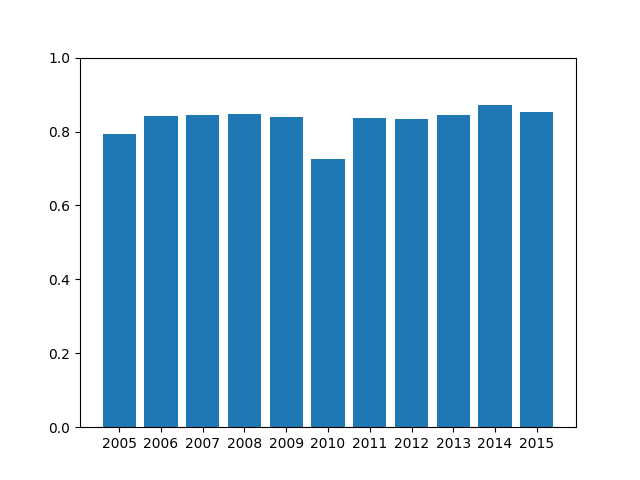

In [21]:
fig4, ax4 = plt.subplots()

ax4.bar(np.arange(11), np.isnan(np.array(EdStatsData.to_numpy()[:,39:50], dtype=float)).mean(axis=0))
ax4.set_xticks(np.arange(11), labels=[f"{x}" for x in range(2005,2016)])
ax4.set_ylim(0,1)
fig4.set(label='Données manquantes par année')
print()

***
### communication

#### Internet users (per 100 people)

In [14]:
EdStatsSeries[EdStatsSeries["Indicator Name"] == 'Internet users (per 100 people)']

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
611,IT.NET.USER.P2,Infrastructure: Communications,Internet users (per 100 people),NaN,Internet users are individuals who have used t...,NaN,Annual,NaN,NaN,Weighted average,...,NaN,Please cite the International Telecommunicatio...,"International Telecommunication Union, World T...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Personal computers (per 100 people)

In [15]:
EdStatsSeries[EdStatsSeries["Indicator Name"] == 'Personal computers (per 100 people)']

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
610,IT.CMP.PCMP.P2,Infrastructure: Communications,Personal computers (per 100 people),NaN,Personal computers are self-contained computer...,NaN,Annual,NaN,NaN,Weighted average,...,NaN,Restricted use: Please cite the International ...,"International Telecommunication Union, World T...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


***
### education

#### Enrolment in tertiary education, all programmes, both sexes (number)

In [16]:
EdStatsSeries[EdStatsSeries["Indicator Name"] == 'Enrolment in tertiary education, all programmes, both sexes (number)']

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
2332,SE.TER.ENRL,Tertiary,"Enrolment in tertiary education, all programme...",NaN,The total number of students enrolled at publi...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Enrolment in secondary education, both sexes (number)

In [17]:
EdStatsSeries[EdStatsSeries["Indicator Name"] == 'Enrolment in secondary education, both sexes (number)']

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
2294,SE.SEC.ENRL,Secondary,"Enrolment in secondary education, both sexes (...",NaN,Total number of students enrolled at public an...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Enrolment in primary education, both sexes (number)

In [18]:
EdStatsSeries[EdStatsSeries["Indicator Name"] == 'Enrolment in primary education, both sexes (number)']

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
2246,SE.PRM.ENRL,Primary,"Enrolment in primary education, both sexes (nu...",NaN,Total number of students enrolled in public an...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***
### economics

#### Income Group

In [66]:
income_groups = pd.unique(EdStatsCountry["Income Group"].dropna())
income_int = [3, 0, 2, 1, 4]
code_list = list(EdStatsCountry["Country Code"])
income_values = list(EdStatsCountry["Income Group"])

def income_cat(x):
    if x!=x :
        return x
    else :
        return income_int[list(income_groups).index(x)]

def get_income_value(country_code):
    try :
        return income_values[code_list.index(country_code)]
    except Exception as e :
        return 'Low Income'

EdStatsData["Income Group"] = EdStatsData["Country Code"].apply(get_income_value)
pd.unique(EdStatsData["Country Name"][EdStatsData["Income Group"]!=EdStatsData["Income Group"]])

array(['Arab World', 'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)', 'European Union',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle income', 'North America', 'OECD members', 'South Asia',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Upper middle income', 'World', 'Gibraltar', 'Nauru'], dtype=object)

#### GNI per capita, Atlas method (current US$)

In [20]:
EdStatsSeries[EdStatsSeries["Indicator Name"] == 'GNI per capita, Atlas method (current US$)']

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
1668,NY.GNP.PCAP.CD,Economic Policy & Debt: National accounts: Atl...,"GNI per capita, Atlas method (current US$)",NaN,GNI per capita (formerly GNP per capita) is th...,NaN,Annual,NaN,NaN,Weighted average,...,NaN,NaN,"World Bank national accounts data, and OECD Na...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


***
### aaa